In [ ]:
## If you do not have the necessary libraries installed, run this cell (only for once)
## Be patient! It takes time.
# for standard libraries such as numpy, scipy, scikit-learn
# I recommend to use the package manager "conda". e.g.,  "conda install scikit-learn"
!pip install persim
!pip install git+https://github.com/shizuo-kaji/CubicalRipser_3dim

  Cloning https://github.com/shizuo-kaji/CubicalRipser_3dim to /tmp/pip-req-build-i2awdmbs
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cripser: filename=cripser-0.0.6-cp37-cp37m-linux_x86_64.whl size=294267 sha256=0e5e694c884fac0b3f10c4b8464b4c2267975b9dfbd9acab4e058f7f5e34b1f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-t9fe68g_/wheels/7b/8e/b1/bf858a2c6c9b80f3f55e1840fc7752c8dd982ab48f6b337df7
Successfully built cripser


In [1]:
## load necessary libraries
%matplotlib inline
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons
import os,time,subprocess,glob
from PIL import Image
import cripser as cr
import tcripser as tcr

In [ ]:
## set the following appropriately
PH_PROG = "../mac/cubicalripser"     ## executable for Mac/Linux
PH_PROG_T = "../mac/tcubicalripser"     ## executable for Mac/Linux for T-construction
#PH_PROG = "CubicalRipser.exe"   ## executable for Windows
IMG_DIR = "./lena/"  ## dir containing images; they must be of the same dimension
volfile = "img.npy"  ## the image files will be combined and saved in this numpy file
ph_out = "PH.npy"    ## the computed persistent homology will be saved in this numpy file

In [ ]:
## 3D example (local jupyter-notebook only, for Google Colab goto the next cell)
# load image files from a dir and stack into a 3D array of type float64
input_files = IMG_DIR+"*.jpg"
files = sorted([f for f in glob.glob(input_files)])
img = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')
print(img.shape, img.dtype, np.min(img),np.max(img))

(512, 512, 9) float64 0.0 255.0


In [ ]:
# create a dummy volume from scikit-learn
import skimage
from skimage import io
from skimage.transform import rotate
im = skimage.data.camera()
io.imsave('img.bmp', im)
np.save('img.npy',im)
img = np.dstack([rotate(im, 10*i) for i in range(8)])
np.save(volfile,img.astype(np.float64))
print(img.shape, img.dtype, np.min(img),np.max(img))

(512, 512, 8) float64 0.0 1.0


In [ ]:
# make binary and apply distance transform
def dt(img,radius=15):
    from scipy.ndimage.morphology import distance_transform_edt
    from skimage.filters import threshold_otsu
#    bw_img = (img >= rank.otsu(img, disk(radius)))
    bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(bw_img)
    return(dt_img)

In [ ]:
# apply distance transform, if you want
#img = dt(img)

In [ ]:
# compute PH for the V-construction with the python wrapper (takes time)
start = time.time()
pd = cr.computePH(img)
print ("elapsed_time:{} sec".format(time.time() - start))
print("Betti numbers: ",[np.sum(pd[:,0] == i) for i in range(3)])


elapsed_time:5.067887306213379 sec
Betti numbers:  [48836, 61957, 16699]


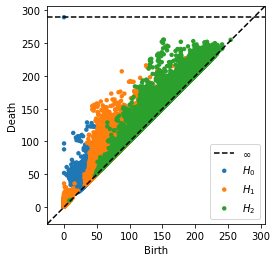

In [ ]:
## plot persistent diagram using persim
%matplotlib inline
import persim
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

elapsed_time:5.959993839263916 sec
Betti numbers:  [25976, 62397, 32712]


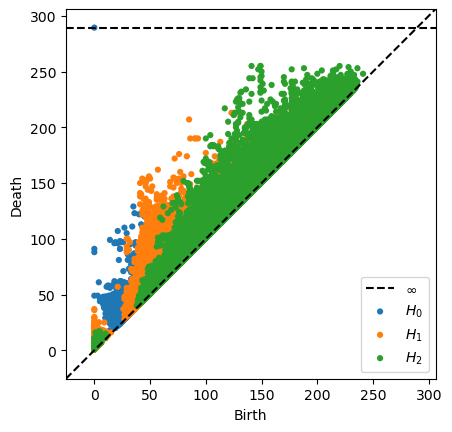

In [ ]:
# compute PH for the T-construction with the python wrapper (takes time)
start = time.time()
pdt = tcr.computePH(img)
print ("elapsed_time:{} sec".format(time.time() - start))
print("Betti numbers: ",[np.sum(pdt[:,0] == i) for i in range(3)])
persim.plot_diagrams([p[:,1:3] for p in [pdt[pdt[:,0] == i] for i in range(3)]])

In [ ]:
# check Alexander duality
pdt2 = cr.computePH(img,embedded=True)
pdt2_reduced = pdt2[ np.abs(pdt2[:,1:3]).max(axis=1)<999999 ]
pdt_reduced = pdt[ np.abs(pdt[:,1:3]).max(axis=1)<999999 ]
print("reduced Betti numbers shold be up side down: ",[np.sum(pdt_reduced[:,0] == i) for i in range(3)],[np.sum(pdt2_reduced[:,0] == i) for i in range(3)])


reduced Betti numbers shold be up side down:  [25975, 62397, 32712] [32712, 62397, 25975]


In [ ]:
# load computed PH
print("#0-cycle {}, #1-cycle {}, #2-cycle {}".format(len(pds[0]),len(pds[1]),len(pds[2])))
# each line contains (dim,birth,death,x,y,z)
print(pds[0][:5])
print(pds[1][:5])
print(pds[2][:5])

In [ ]:
## compute the heatmap of cycles with specified birth-death properties
# the heatmap image reveals what kind of image features are captured by PH
def heat_map(img,pd,h=3,min_life = 10,max_life =255,min_birth = 0,max_birth = 255,dimension = 0,life_weighted=True):
  if len(img.shape)==2:
    mx,my=img.shape
    mz = 1
  else:
    mx,my,mz=img.shape

  selected_cycle = np.zeros((mx,my,mz))
  ppd = pd[pd[:,0] == dimension]
  ppd = ppd[min_life < ppd[:,2]-ppd[:,1]]
  ppd = ppd[ppd[:,2]-ppd[:,1] < max_life]
  ppd = ppd[min_birth < ppd[:,1]]
  ppd = ppd[ppd[:,1] < max_birth]
  w = 1
  for c in ppd:
      x,y,z=int(c[3]),int(c[4]),int(c[5])
      if life_weighted:
        w = c[2]-c[1]
      selected_cycle[max(0,x-h):min(mx,x+h),max(0,y-h):min(my,y+h),max(0,z-h):min(mz,z+h)] += w
#  print(np.min(selected_cycle),np.max(selected_cycle),np.sum(selected_cycle))
  return(np.squeeze(selected_cycle))

In [ ]:
# Visualise the result heatmap (visualisation works only with local jupyter-notebook)
%matplotlib notebook
vol = heat_map(img,pd,dimension=2)
fig = plt.figure()
fig.subplots_adjust(left=0.25, bottom=0.25)
ax = plt.subplot(121)
ind = vol.shape[2]//2
l = ax.imshow(vol[:,:,ind])
ax = plt.subplot(122)
l2 = ax.imshow(img[:,:,ind])
def update(val):
    ind = int(slider.val)
    l.set_data(vol[:,:,ind])
    l2.set_data(img[:,:,ind])
    fig.canvas.draw()        
ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
slider = Slider(ax, 'index', 0, vol.shape[2] - 1, valinit=ind, valfmt='%i')
slider.on_changed(update)
plt.show()

In [ ]:
## load image from disk
img = np.array(Image.open("img.bmp").convert('L'),dtype='f8')
print(img.shape, img.dtype, np.min(img),np.max(img))
start = time.time()
pd = cr.computePH(img)
print ("elapsed_time:{} sec".format(time.time() - start))
print(pd.shape)
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

In [ ]:
## 1D example (scalar timeseries)
%matplotlib inline
x = np.linspace(0,4*np.pi,100)
img = np.sin(x)+0.1*x
plt.plot(x,img)
pd = cr.computePH(img)

In [ ]:
## plot persistence diagram
persim.plot_diagrams(pd[:,1:3])

In [ ]:
## load numpy array from disk
img = np.load("img.npy")
start = time.time()
pd = cr.computePH(img)
print ("elapsed_time:{} sec".format(time.time() - start))
print(pd.shape)
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

In [ ]:
# compute PH with the executable via shell (local jupyter-notebook only)
np.save(volfile,img)
start = time.time()
result = subprocess.run(PH_PROG+' --output '+ph_out+' '+volfile, shell=True)
print(result)
print ("elapsed_time:{} sec".format(time.time() - start))
pd_c = np.load(ph_out)

In [ ]:
# the both method (python and executable) should give the same results
np.array_equal(pd,pd_c)

In [ ]:
!ls

In [ ]:
# compute PH with the executable via shell (local jupyter-notebook only)
# V-construction vs T-construction
np.save(volfile,img)
start = time.time()
result = subprocess.run(PH_PROG_T+' --output '+ph_out+' '+volfile, shell=True)
print(result)
print ("elapsed_time:{} sec".format(time.time() - start))
res = np.load(ph_out)
print("Betti numbers: ", [res[res[:,0]==i].shape[0] for i in range(3)])

# using Alexander duality
start = time.time()
result = subprocess.run(PH_PROG+' --embedded --output '+ph_out+' '+volfile, shell=True)
print(result)
print ("elapsed_time:{} sec".format(time.time() - start))
res = np.load(ph_out)
print("Betti numbers: ", [res[res[:,0]==i].shape[0] for i in range(3)])


CompletedProcess(args='../mac/t-cubicalripser --output PH.npy img.npy', returncode=0)
elapsed_time:20.344515800476074 sec
Betti numbers:  [25976, 62397, 32712]
CompletedProcess(args='../mac/cubicalripser --embedded --output PH.npy img.npy', returncode=0)
elapsed_time:9.113570928573608 sec
Betti numbers:  [32713, 62397, 25976]
